## SHAP local explanation plots

### Step 1: Add a Area of interest around a water body
### Step 2: Run all cells

In [1]:
import ee
ee.Initialize()
import geemap
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import json
import shap
from tqdm import tqdm

### Step 1: Add an area of interest around a water body

In [69]:
countries = ee.FeatureCollection("USDOS/LSIB/2017")
geometry = ee.Geometry.Point([27.7,-25.5])
SA = countries.filterBounds(geometry)
Map= geemap.Map()
Map.centerObject(SA,5)
Map

Map(center=[-28.97574975972159, 25.201998135703736], controls=(WidgetControl(options=['position', 'transparent…

In [70]:
aoi = Map.draw_last_feature
grid = ee.FeatureCollection('users/geethensingh/SA_Grid_1dgr').filterBounds(aoi.geometry()).first()
Map.addLayer(ee.Feature(grid))

In [71]:
df = pd.read_csv(r"C:\Users\coach\myfiles\phd\Chapter_2\nat_drivers\3exports\merged_31082021.csv")
gridid = grid.get('fid').getInfo()
bdf = df.loc[df.fid==gridid].reset_index(drop=True)

In [72]:
def wktPoly_to_gdf(df, geo_col = '.geo' ):
    """
    Function to convert a featureCollection exported from GEE as a csv to a GeoDataFrame
    df: A pandas dataframe
    geo_col: column name in pandas dataframe with well known text (wkt) strings, usually called '.geo'
    """
    gdf = gpd.GeoSeries()
    for i in tqdm(range (0, len(df))):
        res = json.loads(df.iloc[i][geo_col])
        clean_geoms = pd.DataFrame([res], columns =['type','coordinates'])
        data = Polygon(eval(str(clean_geoms.coordinates.iloc[0]))[0])
        gdfe = gpd.GeoSeries(data)
        gdf = gdf.append(gdfe)
#         print(f'Percent complete: {(len(gdf)/len(df)*100)} %')
    return gpd.GeoDataFrame(geometry=gdf, crs= 'EPSG:4326').reset_index(drop=True)

In [73]:
import warnings
warnings.filterwarnings("ignore")
# Convert aoi to geopandas dataframe
aoi_gdf = geemap.ee_to_geopandas(ee.FeatureCollection(aoi))
# print(aoi_gdf.head())

# Convert pandas observations within block to geopandas dataframe
polygons = wktPoly_to_gdf(df=bdf)
polygons = gpd.GeoDataFrame(pd.concat([bdf,polygons],axis=1),geometry= polygons.geometry)
# Get geometry of aoi
polygon = aoi_gdf.geometry[0]

# Select waterbodies within aoi
waterbodies = polygons[polygons.within(polygon)]
# print(len(waterbodies))

100%|█████████████████████████████████████████████████████████████████████████████| 2158/2158 [00:02<00:00, 759.82it/s]


<AxesSubplot:>

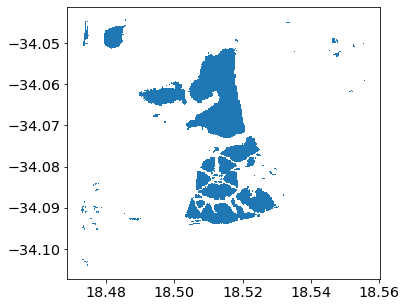

In [74]:
waterbodies.plot()

In [75]:
warea = waterbodies.copy()
warea= warea.to_crs({'init': 'epsg:3857'})
print (warea.crs)
warea["area"] = warea['geometry'].area/ 10**6

+init=epsg:3857 +type=crs


<AxesSubplot:>

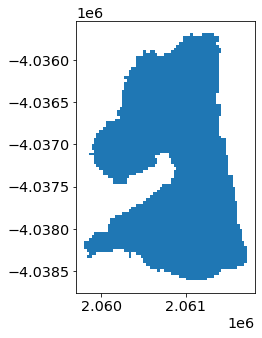

In [76]:
wb = warea[warea.area == warea.area.max()]
wb.plot()

In [77]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
shap.initjs()

In [78]:
# df = pd.read_csv(r"D:\phd\Chapter_2\nat_drivers\3exports\merged_14052021_complete.csv")
df = pd.read_csv(r"C:\Users\coach\myfiles\phd\Chapter_2\nat_drivers\3exports\merged_31082021.csv")

In [79]:
FLC = ['contiguous (indigenous) forest',
 'contiguous low forest & thicket',
 'dense forest & woodland',
 'open woodland',
 'contiguous & dense plantation forest',
 'open & sparse plantation forest',
 'temporary unplanted (clear-felled) plantation forest',
 'low shrubland (other)',
 'low shrubland (fynbos)',
 'low shrubland (succulent karoo)',
 'low shrubland (nama karoo)',
 'sparsely wooded grassland',
 'natural grassland',
 'natural rivers',
 'natural estuaries & lagoons',
 'natural ocean & coastal',
 'natural lakes',
 'natural pans (flooded @ observation times)',
 'artificial dams (including canals)',
 'artificial sewage ponds',
 'artificial flooded mine pits',
 'herbaceous wetlands (currently mapped)',
 'herbaceous wetlands (previously mapped)',
 'mangrove wetlands',
 'natural rock surfaces',
 'dry pans',
 'eroded lands',
 'sand dunes (terrestrial)',
 'coastal sand & dunes',
 'bare riverbed material',
 'other bare',
 'cultivated commercial permanent orchards',
 'cultivated commercial permanent vines',
 'cultivated commercial sugarcane pivot irrigated',
 'cultivated commercial permanent pineapples',
 'cultivated commercial sugarcane non-pivot',
 'cultivated emerging farmer sugarcane non-pivot',
 'commercial annual crops pivot irrigated',
 'commercial annual crops non-pivot irrigated',
 'commercial annual crops rain-fed / dryland',
 'subsistence / small-scale annual crops',
 'fallow land & old fields (trees)',
 'fallow land & old fields (bush)',
 'fallow land & old fields (grass)',
 'fallow land & old fields (bare)',
 'fallow land & old fields (low shrub)',
 'residential formal (tree)',
 'residential formal (bush)',
 'residential formal (low veg / grass)',
 'residential formal (bare)',
 'residential informal (tree)',
 'residential informal (bush)',
 'residential informal (low veg / grass)',
 'residential informal (bare)',
 'village scattered (bare & low veg/ grss combo)',
 'village dense (bare & low veg / grss combo)',
 'smallholdings (tree)',
 'smallholdings (bush)',
 'smallholdings (low veg / grass)',
 'smallholdings (bare)',
 'urban recreational fields (tree)',
 'urban recreational fields (bush)',
 'urban recreational fields (grass)',
 'urban recreational fields (bare)',
 'commercial',
 'industrial',
 'roads & rails (major linear)',
 'mines: surface infrastructure',
 'mines: extraction pits, quarries',
 'mines: salt mines',
 'mine: tailings and resource dumps',
 'land-fills',
 'fallow land & old fields (wetlands)']

In [80]:
df = df.dropna(subset=['pxid'])

rep0 = ['flood','wSeasonality', 'aq_veg_area', 'rwi']
df[rep0+FLC] = df[rep0+FLC].fillna(0)

In [81]:
top_features = ['CHILI', 'Global_Human_Modification', 'SPI', 'bare-coverfraction',
       'cation_ex_capacity', 'clay_content', 'commercial',
       'commercial annual crops rain-fed / dryland',
       'contiguous & dense plantation forest',
       'contiguous (indigenous) forest', 'crops-coverfraction',
       'cultivated commercial permanent pineapples',
       'cultivated commercial sugarcane non-pivot', 'dense forest & woodland',
       'distance_to_roads', 'dsrcnt', 'fcc', 'flood', 'grass-coverfraction',
       'herbaceous wetlands (previously mapped)', 'industrial',
       'low shrubland (fynbos)', 'low shrubland (nama karoo)',
       'mangrove wetlands', 'minT', 'mines: surface infrastructure',
       'natural rock surfaces', 'nitrogen_total',
       'open & sparse plantation forest', 'precipitation',
       'roads & rails (major linear)', 'runoff', 'sand_content',
       'shrub-coverfraction', 'soc_100-200cm_mean',
       'sparsely wooded grassland', 'stone_content',
       'subsistence / small-scale annual crops',
       'temporary unplanted (clear-felled) plantation forest', 'topD',
       'tree-coverfraction', 'urban-coverfraction', 'wSeasonality',
       'water-permanent-coverfraction', 'water-seasonal-coverfraction',
       'wind_speed', 'contiguous low forest & thicket',
       'cultivated commercial permanent orchards',
       'cultivated commercial permanent vines',
       'low shrubland (succulent karoo)', 'natural estuaries & lagoons',
       'natural grassland', 'natural rivers', 'land-fills',
       'mine: tailings and resource dumps', 'mines: extraction pits, quarries',
       'mines: salt mines', 'natural lakes', 'natural ocean & coastal',
       'natural pans (flooded @ observation times)',
       'commercial annual crops pivot irrigated',
       'cultivated emerging farmer sugarcane non-pivot',
       'fallow land & old fields (bush)', 'fallow land & old fields (trees)',
       'residential formal (bare)', 'residential formal (bush)',
       'residential formal (low veg / grass)', 'residential informal (tree)',
       'urban recreational fields (bush)', 'urban recreational fields (tree)',
       'village scattered (bare & low veg/ grss combo)', 'aq_veg_area',
       'smallholdings (low veg / grass)', 'residential informal (bush)',
       'open woodland', 'cultivated commercial sugarcane pivot irrigated',
       'coastal sand & dunes', 'sand dunes (terrestrial)',
       'artificial dams (including canals)', 'artificial flooded mine pits',
       'artificial sewage ponds', 'low shrubland (other)']
df = df[[*top_features, 'label', 'fid', '.geo', 'Unnamed: 0']]

feature_names = ['Microclimate - Continous Heat Insolation Index (CHILI)', 'Global human modification', 'Stream power index', 'Bare-coverfraction',
       'Cation exchange capacity', 'Clay content', 'Commercial',
       'Commercial annual crops rain-fed / dryland',
       'Contiguous & dense plantation forest',
       'Contiguous (indigenous) forest', 'Crops-coverfraction',
       'Cultivated commercial permanent pineapples',
       'Cultivated commercial sugarcane non-pivot', 'Dense forest & woodland',
       'Distance_to_roads', 'Connectivity - Number of downstream rivers',
        'Fertility Capability Classification', 'Flood risk', 'Grass-coverfraction',
       'Herbaceous wetlands (previously mapped)', 'Industrial',
       'Low shrubland (fynbos)', 'Low shrubland (nama karoo)',
       'Mangrove wetlands', 'Minimum Temperature in the coldest month (1970-1990)', 'Mines: surface infrastructure',
       'Natural rock surfaces', 'Total riparian nitrogen',
       'Open & sparse plantation forest', 'Precipitation',
       'Roads & rails (major linear)', 'Runoff', 'Riparian soil content',
       'Shrub-coverfraction', 'Soil organic carbon (100-200cm)',
       'Sparsely wooded grassland', 'Stone_content',
       'Subsistence / small-scale annual crops',
       'Temporary unplanted (clear-felled) plantation forest', 'Microclimate - topographic diversity',
       'Tree-coverfraction', 'Urban-coverfraction', 'Surface water persistence',
       'Water-permanent-coverfraction', 'Water-seasonal-coverfraction',
       'Wind speed', 'Contiguous low forest & thicket',
       'Cultivated commercial permanent orchards',
       'Cultivated commercial permanent vines',
       'Low shrubland (succulent karoo)', 'Natural estuaries & lagoons',
       'Natural grassland', 'Natural rivers', 'Land-fills',
       'Mine: tailings and resource dumps', 'Mines: extraction pits, quarries',
       'Mines: salt mines', 'Natural lakes', 'Natural ocean & coastal',
       'Natural pans (flooded at observation times)',
       'Commercial annual crops pivot irrigated',
       'Cultivated emerging farmer sugarcane non-pivot',
       'Fallow land & old fields (bush)', 'Fallow land & old fields (trees)',
       'Residential formal (bare)', 'Residential formal (bush)',
       'Residential formal (low veg / grass)', 'Residential informal (tree)',
       'Urban recreational fields (bush)', 'Urban recreational fields (tree)',
       'Village scattered (bare & low veg/ grss combo)', 'Interspecies competition - area of aquatic vegetation',
       'Smallholdings (low veg / grass)', 'Residential informal (bush)',
       'Open woodland', 'Cultivated commercial sugarcane pivot irrigated',
       'Coastal sand & dunes', 'Sand dunes (terrestrial)',
       'Artificial dams (including canals)', 'Artificial flooded mine pits',
       'Artificial sewage ponds', 'Low shrubland (other)']

df.columns = [*feature_names, 'label', 'fid', '.geo', 'Unnamed: 0']
df = df.dropna().reset_index(drop=True)

top_features = feature_names

In [82]:
params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 542, 'bootstrap': False}

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(**params, random_state=123, n_jobs = -1)

In [83]:
from sklearn.model_selection import GroupKFold, cross_val_predict
blocks = df['fid'].values
group_kfold = GroupKFold(n_splits=10)
# Generator for the train/test indices
# block_kfold = group_kfold.split(X, y, blocks)  
# Create a nested list of train and test indices for each fold
# train_indices, test_indices = [list(traintest) for traintest in zip(*block_kfold)]
# block_cv = [*zip(train_indices,test_indices)]
# predictions = cross_val_predict(model, X, y, cv=block_cv)

In [84]:
#loading and preparing the data
X = df[feature_names]
y = df[['label']]
columns = list(X)

groups = df['fid'].values
group_kfold = GroupKFold(n_splits=10)

for train_index, test_index in tqdm(group_kfold.split(X, y, groups=groups)):
    select_indices = list(np.where(df["Unnamed: 0"] == wb["Unnamed: 0"].values[0])[0])
    if X.iloc[select_indices].index.values[0] in test_index:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = pd.DataFrame(X_train,columns=columns)
        X_test = pd.DataFrame(X_test,columns=columns)
        
        #training model
        clf.fit(X_train, y_train.values.ravel())

        #explaining model
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X.iloc[select_indices])
        expected_values = explainer.expected_value

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


10it [03:08, 18.89s/it]


# Force Plot

In [85]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [86]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], feature_names = list(X), show=False)

The expected value is  0.11373601789709101


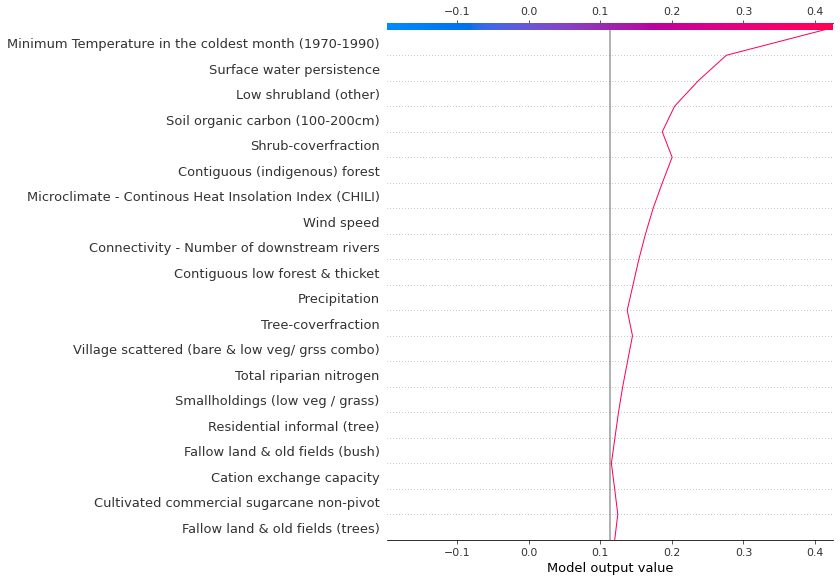

In [87]:
expected_value = explainer.expected_value[1]
print("The expected value is ", expected_value)
shap_values = explainer.shap_values(X.iloc[select_indices])[1]
shap.decision_plot(expected_value, shap_values, feature_names = list(X), show=False)

In [89]:
import matplotlib.pyplot as plt
shap_values = explainer(X.iloc[select_indices])
values = shap_values.values[0][:,1]
values = np.where(np.isnan(values), 0, values)
base_values = shap_values.base_values[0][1]

tmp = shap.Explanation(values = values,
                       base_values = base_values,
                       data = X.iloc[select_indices].values[0],
                      feature_names = list(X))
shap.plots.waterfall(tmp)#, show = False
# plt.savefig(r'C:\Users\coach\myfiles\phd\Chapter_2\nat_drivers\4results\figures2\roodeplaat_waterfall.png', dpi = 500, transparent=True, bbox_inches='tight')

AttributeError: 'Explanation' object has no attribute 'set_xlabel'